# Assembly Line Anomaly Detection using CNN-based Autoencoder
This notebook trains a convolutional autoencoder for anomaly detection on the MVTec Anomaly Detection dataset.

In [3]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


In [4]:

# Set dataset path
DATASET_PATH = "D:/Deep learning/mvtec_anomaly_detection"
PROCESSED_PATH = "processed_data"
IMAGE_SIZE = (128, 128)  # Reduce size to avoid memory issues

# Create processed folder if not exists
if not os.path.exists(PROCESSED_PATH):
    os.makedirs(PROCESSED_PATH)


In [ ]:

def is_image_file(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))

def preprocess_image(image_path):
    if not os.path.isfile(image_path):
        print(f"Skipping non-file: {image_path}")
        return None
    
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Failed to read image: {image_path}")
        return None

    image = cv2.resize(image, IMAGE_SIZE)
    image = image.astype(np.float32) / 255.0
    return image

def load_good_images():
    data, labels = [], []

    for category in os.listdir(DATASET_PATH):
        category_path = os.path.join(DATASET_PATH, category, 'train', 'good')
        
        if not os.path.exists(category_path) or not os.path.isdir(category_path):
            continue
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            if is_image_file(img_name):
                image = preprocess_image(img_path)
                if image is not None:
                    data.append(image)
                    labels.append(0)
    
    return np.array(data), np.array(labels)

data, labels = load_good_images()
print(f"Total Images Loaded: {len(data)}")

# Train-test split
train_images, val_images, train_labels, val_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

# Save preprocessed data
np.save(os.path.join(PROCESSED_PATH, "train_images.npy"), train_images)
np.save(os.path.join(PROCESSED_PATH, "val_images.npy"), val_images)


Total Images Loaded: 3629


In [6]:
train_images.shape

(2903, 128, 128, 3)

In [ ]:

# Define Autoencoder Model
input_img = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

: 

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    train_images, train_images,
    epochs=100,
    batch_size=8,
    validation_data=(val_images, val_images),
    callbacks=[early_stopping]
)

print("Training completed!")


Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 86s 226ms/step - loss: 0.0247 - val_loss: 0.0060
Epoch 2/100
199/363 ━━━━━━━━━━━━━━━━━━━━ 47s 288ms/step - loss: 0.0056

In [ ]:
autoencoder.save("my_model.keras")  # Saves in the recommended format


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Skipping missing category: mvtec_ad_evaluation
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Skipping missing category: processed_data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


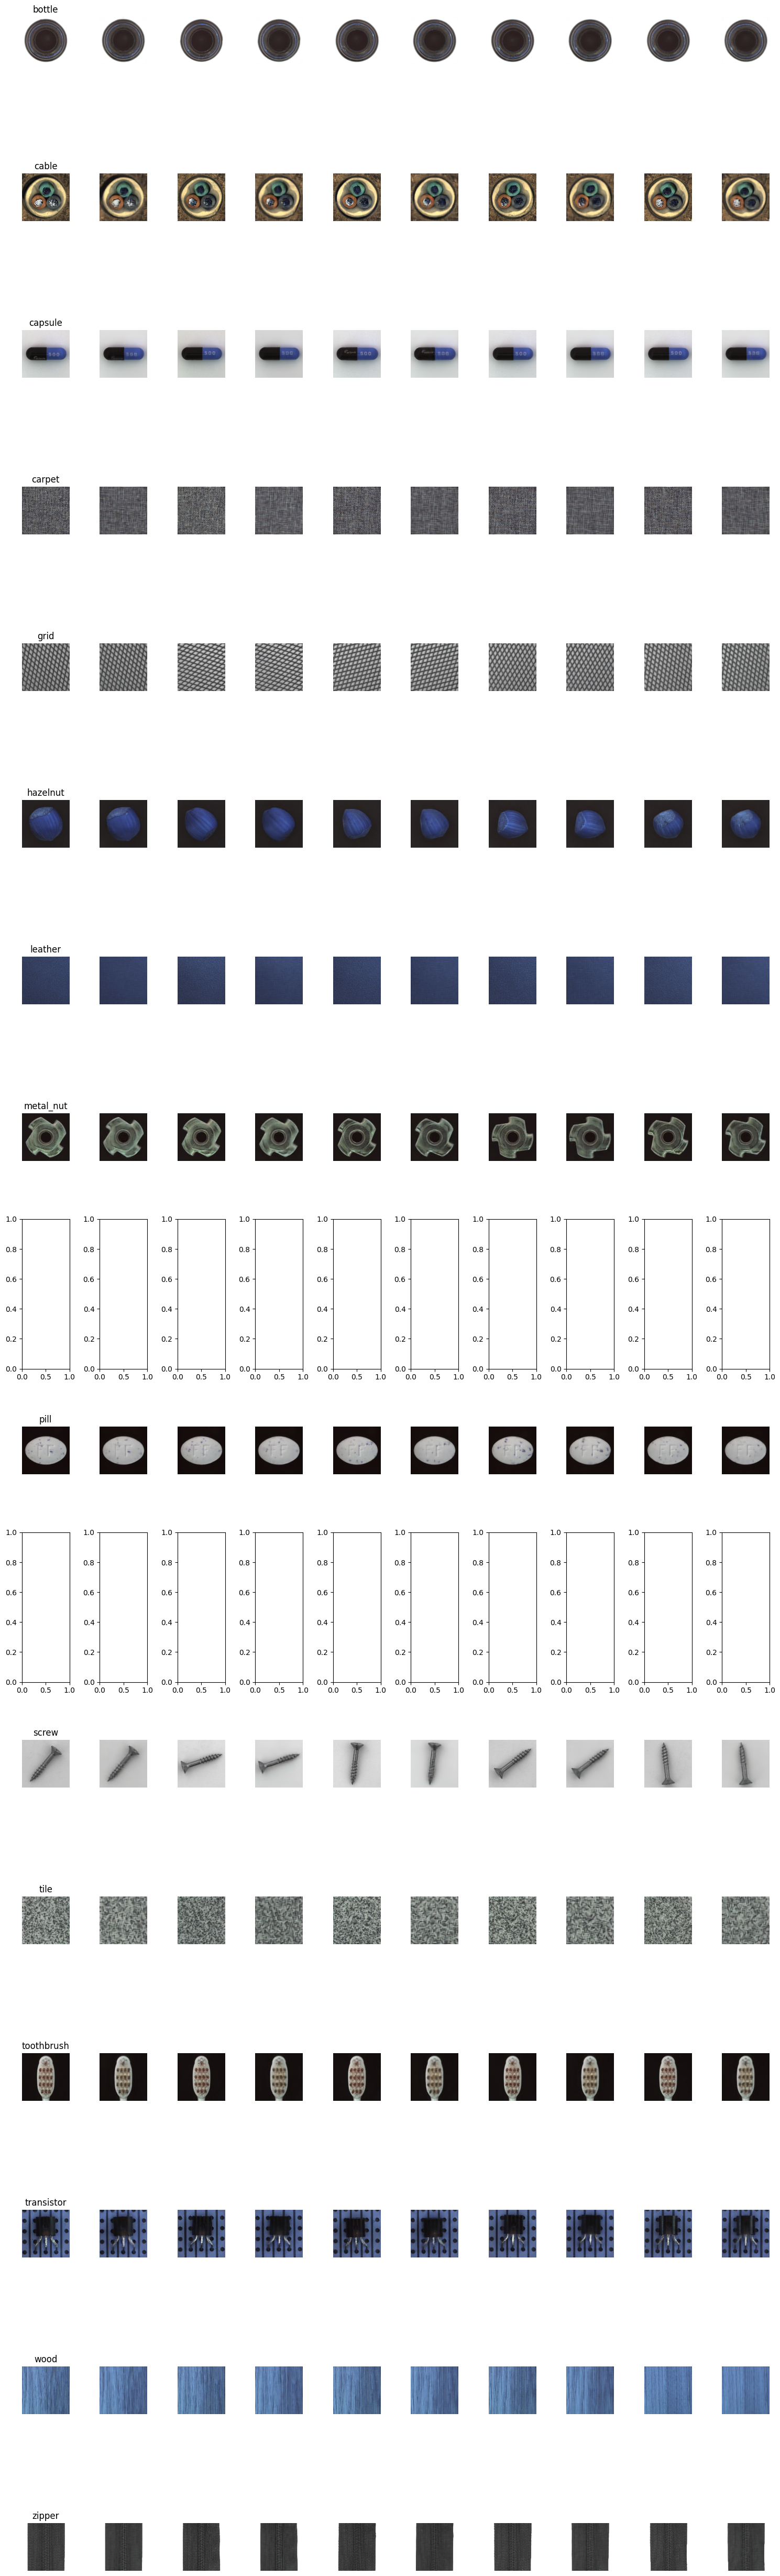

In [ ]:
 def visualize_reconstruction_per_category(dataset_path, model, num_images=5):
    categories = os.listdir(dataset_path)
    num_categories = len(categories)
    
    fig, axes = plt.subplots(num_categories, num_images * 2, figsize=(num_images * 3, num_categories * 3))

    for row, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category, 'train', 'good')
        
        if not os.path.exists(category_path) or not os.path.isdir(category_path):
            print(f"Skipping missing category: {category}")
            continue
        
        # Get image paths
        img_files = [f for f in os.listdir(category_path) if is_image_file(f)][:num_images]
        
        test_images = [preprocess_image(os.path.join(category_path, img)) for img in img_files]
        test_images = [img for img in test_images if img is not None]  # Remove None values
        
        if len(test_images) == 0:
            continue

        test_images = np.array(test_images)
        reconstructions = model.predict(test_images)

        for col in range(len(test_images)):
            axes[row, col * 2].imshow(test_images[col])
            axes[row, col * 2].axis('off')
            axes[row, col * 2 + 1].imshow(reconstructions[col])
            axes[row, col * 2 + 1].axis('off')

        axes[row, 0].set_title(category, fontsize=12)

    plt.tight_layout()
    plt.show()

# Call the function
visualize_reconstruction_per_category(DATASET_PATH, autoencoder)


In [ ]:
def calculate_error(test_images, model):
    """Calculate Mean Absolute Error (MAE) for each image."""
    reconstructions = model.predict(test_images)
    errors = np.mean(np.abs(test_images - reconstructions), axis=(1, 2, 3))
    return errors

def detect_anomalies_per_category(dataset_path, model):
    """Detect anomalies for each category separately."""
    categories = os.listdir(dataset_path)
    results = {}

    for category in categories:
        category_path = os.path.join(dataset_path, category, 'train', 'good')
        
        if not os.path.exists(category_path) or not os.path.isdir(category_path):
            print(f"Skipping missing category: {category}")
            continue
        
        img_files = [f for f in os.listdir(category_path) if is_image_file(f)]
        test_images = [preprocess_image(os.path.join(category_path, img)) for img in img_files]
        test_images = [img for img in test_images if img is not None]

        if len(test_images) == 0:
            continue

        test_images = np.array(test_images)
        errors = calculate_error(test_images, model)

        # Compute category-specific threshold (3-sigma rule)
        threshold = np.mean(errors) + 3 * np.std(errors)
        
        # Detect anomalies
        anomalies = errors > threshold
        num_anomalies = np.sum(anomalies)

        results[category] = {
            "total_images": len(test_images),
            "anomalies_detected": num_anomalies,
            "threshold": threshold,
        }

        print(f"Category: {category}, Anomalies: {num_anomalies}/{len(test_images)}, Threshold: {threshold:.4f}")

    return results

# Run the function
anomaly_results = detect_anomalies_per_category(DATASET_PATH, autoencoder)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step
Category: bottle, Anomalies: 0/209, Threshold: 0.0180
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
Category: cable, Anomalies: 0/224, Threshold: 0.0501
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step
Category: capsule, Anomalies: 6/219, Threshold: 0.0139
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step
Category: carpet, Anomalies: 4/280, Threshold: 0.0771
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step
Category: grid, Anomalies: 0/264, Threshold: 0.0584
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step
Category: hazelnut, Anomalies: 5/391, Threshold: 0.0150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step
Category: leather, Anomalies: 2/245, Threshold: 0.0305
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
Category: metal_nut, Anomalies: 1/220, Threshold: 0.0292
Skipping missing category: mvtec_ad_evaluation
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step
Category: pill, Anomalies: 0/267, Threshold: 0.0110
Skipping missing category: processed_data
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step
Category: screw, Anomalies: 7

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(anomaly_scores, bins=50, alpha=0.7, color='blue', label="Reconstruction Error")
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label="Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.show()


NameError: name 'anomaly_scores' is not defined

<Figure size 800x500 with 0 Axes>

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report

def load_images_with_labels(base_path):
    images = []
    labels = []
    
    # Iterate through each category folder
    for category in os.listdir(base_path):
        category_path = os.path.join(base_path, category)
        if not os.path.isdir(category_path):
            continue  # Skip non-folder files

        # Load anomalous images from "test" folder (excluding "good")
        test_path = os.path.join(category_path, "test")
        if os.path.exists(test_path):
            for subfolder in os.listdir(test_path):
                if subfolder.lower() == "good":  # Skip good images
                    continue  
                subfolder_path = os.path.join(test_path, subfolder)
                for filename in os.listdir(subfolder_path):
                    img_path = os.path.join(subfolder_path, filename)
                    img = cv2.imread(img_path)  # Load image
                    if img is not None:
                        images.append(img)
                        labels.append(1)  # Anomalous label

        # Load normal images from "train/good"
        train_good_path = os.path.join(category_path, "train", "good")
        if os.path.exists(train_good_path):
            for filename in os.listdir(train_good_path):
                img_path = os.path.join(train_good_path, filename)
                img = cv2.imread(img_path)  # Load image
                if img is not None:
                    images.append(img)
                    labels.append(0)  # Normal label

    return np.array(images), np.array(labels)

def preprocess_images(images, target_size=(128, 128)):
    processed_images = []
    for img in images:
        img = cv2.resize(img, target_size)  # Resize
        img = img.astype("float32") / 255.0  # Normalize
        processed_images.append(img)
    return np.array(processed_images)

def calculate_error(test_images, model):
    reconstructions = model.predict(test_images)
    errors = np.mean(np.abs(test_images - reconstructions), axis=(1, 2, 3))
    return errors

def detect_anomalies(test_images, threshold, model):
    errors = calculate_error(test_images, model)
    anomalies = errors > threshold
    return anomalies, errors

# Set base directory
base_directory = r"D:\Deep learning\mvtec_anomaly_detection"

# Load dataset
images, true_labels = load_images_with_labels(base_directory)
images = preprocess_images(images)  # Resize & Normalize

# Detect anomalies
errors = calculate_error(images, autoencoder)
threshold = np.mean(errors) + 3 * np.std(errors)  # Define threshold
anomalies, anomaly_scores = detect_anomalies(images, threshold, autoencoder)

# Classification report
predicted_labels = anomalies.astype(int)
print(classification_report(true_labels, predicted_labels))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_anomalies(test_images, anomalies, model):
    # Convert anomalies array to boolean (if it's not already)
    anomalies = anomalies.astype(bool)
    
    # Get anomalous images
    anomalous_images = test_images[anomalies]
    
    # If no anomalies, return
    if len(anomalous_images) == 0:
        print("No anomalies detected.")
        return
    
    # Get reconstructions
    reconstructions = model.predict(anomalous_images)

    num_images = min(len(anomalous_images), 5)  # Show up to 5 images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    # Ensure axes is always a 2D array (to avoid index errors)
    axes = np.atleast_2d(axes)

    for i in range(num_images):
        axes[0, i].imshow(anomalous_images[i])
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructions[i])
        axes[1, i].axis('off')

    axes[0, 0].set_title("Anomalous Images")
    axes[1, 0].set_title("Reconstructed Images")
    plt.show()

# Call the function
visualize_anomalies(val_images, anomalies, autoencoder)


NameError: name 'val_images' is not defined